<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/aichi/aichi_patients_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tabula-py

     |████████████████████████████████| 11.7MB 8.7MB/s 


In [2]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 9.0MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120276 sha256=0090f1d54570ad51435994385161820465ba7fa61f237bac57256e270a7ca037
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [3]:
import datetime
import hashlib
import pathlib
import re
from urllib.parse import urljoin

In [4]:
from tabula import read_pdf
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib

In [6]:
from google.colab import files

In [7]:
aichi_cities = [
    "名古屋市",
    "一宮市",
    "瀬戸市",
    "春日井市",
    "犬山市",
    "江南市",
    "小牧市",
    "稲沢市",
    "尾張旭市",
    "岩倉市",
    "豊明市",
    "日進市",
    "清須市",
    "北名古屋市",
    "長久手市",
    "東郷町",
    "豊山町",
    "大口町",
    "扶桑町",
    "津島市",
    "愛西市",
    "弥富市",
    "あま市",
    "大治町",
    "蟹江町",
    "飛島村",
    "半田市",
    "常滑市",
    "東海市",
    "大府市",
    "知多市",
    "阿久比町",
    "東浦町",
    "南知多町",
    "美浜町",
    "武豊町",
    "岡崎市",
    "碧南市",
    "刈谷市",
    "豊田市",
    "安城市",
    "西尾市",
    "知立市",
    "高浜市",
    "みよし市",
    "幸田町",
    "豊橋市",
    "豊川市",
    "蒲郡市",
    "新城市",
    "田原市",
    "設楽町",
    "東栄町",
    "豊根村",
]

In [8]:
ages_list = [
    "10歳未満",
    "10代",
    "20代",
    "30代",
    "40代",
    "50代",
    "60代",
    "70代",
    "80代",
    "90代",
    "100代",
]

In [9]:
def fetch_file(url, filename):

    p = pathlib.Path(filename)
    p.parent.mkdir(parents=True, exist_ok=True)

    if not p.exists():

        r = requests.get(url)
        r.raise_for_status()

        with p.open(mode="wb") as fw:
            fw.write(r.content)

    return p

In [10]:
def days2date(s):

    y = 2021 if s.name > 16576 else 2020

    days = re.findall("[0-9]{1,2}", s["発表日"])

    if len(days) == 2:
        m, d = map(int, days)
        return pd.Timestamp(year=y, month=m, day=d)
    else:
        return pd.NaT

# スクレイピング

In [11]:
url = "https://www.pref.aichi.jp/site/covid19-aichi/"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko"
}

In [12]:
JST = datetime.timezone(datetime.timedelta(hours=+9), "JST")
dt_now = datetime.datetime.now(JST).replace()

In [13]:
r = requests.get(url, headers=headers)
r.raise_for_status()

soup = BeautifulSoup(r.content, "html.parser")

# ファイルチェック

In [14]:
def pdf2df(url, fn):

    fp_pdf = fetch_file(url, fn)
    fp_pkl = fp_pdf.with_suffix(".plk")
    fp_sha = fp_pdf.with_suffix(".sha256")

    hash = ""
    filename = ""

    if fp_pkl.exists():

        hash, filename = fp_sha.read_text().split()

    checksum = hashlib.sha256(fp_pdf.read_bytes()).hexdigest()

    print(checksum)

    if (hash != checksum) or (not fp_pkl.exists()) or (fn != filename):

        df = pd.concat(read_pdf(fp_pdf, pages="all", lattice=True))

        df.to_pickle(fp_pkl)
        fp_sha.write_text(f"{checksum} {fn}")

    else:
        df = pd.read_pickle(fp_pkl)

    return df

In [15]:
tags = soup.find("span", text="▶ 愛知県内の発生事例").parent.find_all("a", href=re.compile(".pdf$"))
links = [urljoin(url, i.get("href")) for i in tags[::-1]]

In [67]:
df1 = pdf2df(links[0], "source1.pdf")

832e1bbf2fb9b9d7e9bee66c81ee39402569434009bee25c959c020716c98b83


In [68]:
df2 = pdf2df(links[1], "source2.pdf")

ac6b716d534148fb5e98c3c73d97932b728ee71083d56335f976a7e0ca040812


In [18]:
df = pd.concat([df1, df2]).set_index("No")

# 前処理

In [19]:
# 発表日が欠損を削除
df.dropna(subset=["発表日"], inplace=True)

In [20]:
# Noでソート
df.index = df.index.astype(int)
df.sort_index(inplace=True)

In [21]:
# 発表日をdatetimeに変換
number_date = df.apply(days2date, axis=1)

In [22]:
df_date = df["発表日"].str.extract("(\d{1,2})月(\d{1,2})日").rename(columns={0: "month", 1: "day"}).astype(int)
ser = df_date["month"] - df_date["month"].shift(1, fill_value=0)

In [23]:
# 12から1に変わるとカウント
df_date["year"] = 2020 + (ser == -11).cumsum()

df["発表日"] = pd.to_datetime(df_date)

In [24]:
# Noと違う日付をチェック
df[df["発表日"] != number_date]

,発表日,年代・性別,国籍,住居地,接触状況,備考
No,,,,,,


In [25]:
# 未来の日付チェック
df[df["発表日"] > dt_now.replace(tzinfo=None)]

,発表日,年代・性別,国籍,住居地,接触状況,備考
No,,,,,,


In [26]:
cjk = str.maketrans("⻲⻑黑戶⻯⻄⻘⻤", "亀長黒戸竜西青鬼")

In [27]:
# 文字コード正規化
df["住居地"] = df["住居地"].fillna("").str.normalize("NFKC")
df["住居地"] = df["住居地"].apply(lambda s: s.translate(cjk))

df["年代・性別"] = df["年代・性別"].str.normalize("NFKC").str.replace(" ", "")

In [28]:
# 年代と性別を分割
df_ages = df["年代・性別"].str.extract("(.+)(男性|女性|その他)").rename(columns={0: "年代", 1: "性別"})
df = df.join(df_ages)

In [29]:
# 前後の空白削除
df["年代"] = df["年代"].str.strip()

In [30]:
df.to_csv("aichi.csv", encoding="utf_8_sig")
# files.download("aichi.csv")

# 抽出

In [31]:
flag = (
    (df["接触状況"].str.contains("再感染"))
    | (df["住居地"] == "中国武漢市")
    | df.index.isin((1095, 1610, 2085, 2536, 8896, 12906))
)

In [32]:
flag.sum()

30

In [33]:
df[flag]

,発表日,年代・性別,国籍,住居地,接触状況,備考,年代,性別
No,,,,,,,,
1,2020-01-26,40代男性,中国,中国武漢市,中国,本県発表1,40代,男性
2,2020-01-28,40代男性,中国,中国武漢市,中国,本県発表2,40代,男性
190,2020-04-02,40代女性,日本,名古屋市,再感染(No.54),名古屋市発表127,40代,女性
356,2020-04-15,20代女性,NaN,名古屋市,再感染(No.35),名古屋市発表204,20代,女性
391,2020-04-18,90代女性,NaN,名古屋市,再感染(No.85),名古屋市発表224,90代,女性
392,2020-04-18,60代男性,NaN,名古屋市,再感染(No.154),名古屋市発表225,60代,男性
491,2020-05-03,60代女性,日本,知多市,再感染(No.353),本県発表197,60代,女性
506,2020-05-14,30代女性,NaN,名古屋市,再感染(No.355),名古屋市発表277,30代,女性
520,2020-06-15,70代男性,NaN,名古屋市,再感染(No.500),名古屋市発表283,70代,男性


In [34]:
df = df[~flag]

# 陽性者数

In [35]:
s = df["発表日"].value_counts().sort_index().asfreq("D", fill_value=0)

<BarContainer object of 354 artists>

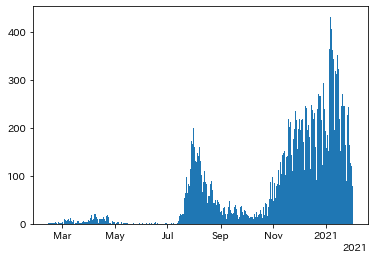

In [36]:
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.bar(s.index, s, width=1)

In [37]:
# 直近14日
s.tail(14)

2021-01-19    246
2021-01-20    245
2021-01-21    270
2021-01-22    246
2021-01-23    246
2021-01-24    164
2021-01-25     89
2021-01-26    215
2021-01-27    227
2021-01-28    244
2021-01-29    163
2021-01-30    126
2021-01-31    121
2021-02-01     79
Freq: D, Name: 発表日, dtype: int64

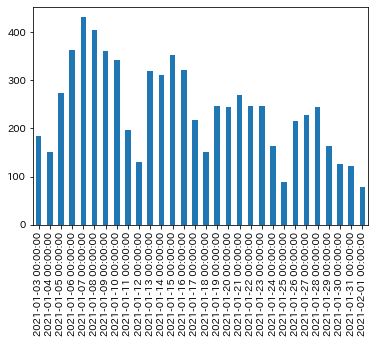

In [38]:
s.tail(30).plot.bar()

# 住所地

## 県内

In [39]:
df_kennai = df[df["住居地"].isin(aichi_cities)]

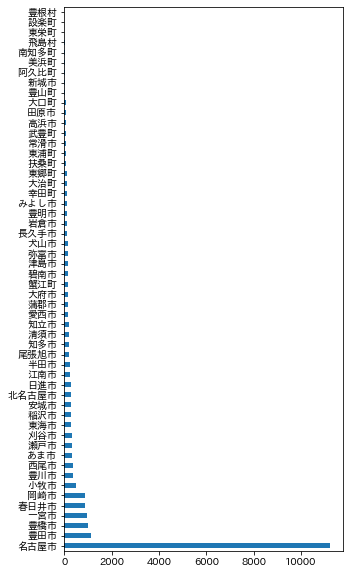

In [40]:
# 県内
df_kennai["住居地"].value_counts().plot.barh(figsize=(5, 10))

In [41]:
df_kennai["住居地"].value_counts()

名古屋市     11218
豊田市       1113
豊橋市        997
一宮市        962
春日井市       887
岡崎市        866
小牧市        489
豊川市        367
西尾市        363
あま市        341
瀬戸市        328
刈谷市        325
東海市        305
稲沢市        292
安城市        281
北名古屋市      269
日進市        268
江南市        261
半田市        254
尾張旭市       218
知多市        213
清須市        207
知立市        190
愛西市        180
蒲郡市        178
大府市        174
蟹江町        166
碧南市        165
津島市        161
弥富市        157
犬山市        140
長久手市       139
岩倉市        134
豊明市        129
みよし市       123
幸田町        114
大治町        110
東郷町         98
扶桑町         95
東浦町         86
常滑市         86
武豊町         86
高浜市         77
田原市         67
大口町         67
豊山町         51
新城市         49
阿久比町        33
美浜町         26
南知多町        24
飛島村         17
東栄町          3
設楽町          2
豊根村          1
Name: 住居地, dtype: int64

In [42]:
df_kennai.to_csv("kennai.csv", encoding="utf_8_sig")
# files.download("kennai.csv")

## 県外

In [43]:
df_kengai = df[~df["住居地"].isin(aichi_cities)]

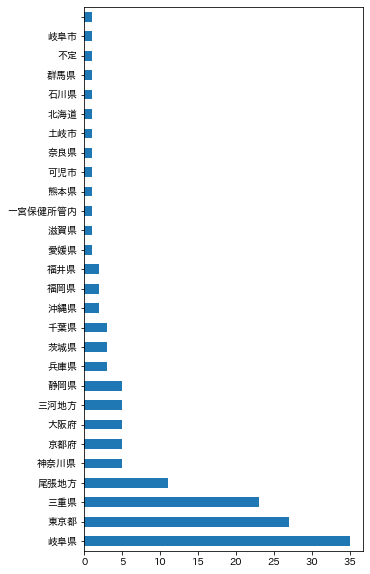

In [44]:
# 県外
df_kengai["住居地"].value_counts().plot.barh(figsize=(5, 10))

In [45]:
df_kengai["住居地"].value_counts()

岐阜県        35
東京都        27
三重県        23
尾張地方       11
神奈川県        5
京都府         5
大阪府         5
三河地方        5
静岡県         5
兵庫県         3
茨城県         3
千葉県         3
沖縄県         2
福岡県         2
福井県         2
愛媛県         1
滋賀県         1
一宮保健所管内     1
熊本県         1
可児市         1
奈良県         1
土岐市         1
北海道         1
石川県         1
群馬県         1
不定          1
岐阜市         1
            1
Name: 住居地, dtype: int64

In [46]:
df_kengai.to_csv("kengai.csv", encoding="utf_8_sig")
# files.download("kengai.csv")

## 置換

In [47]:
# 県外に置換
df["住居地"] = df["住居地"].where(df["住居地"].isin(aichi_cities), "県外")

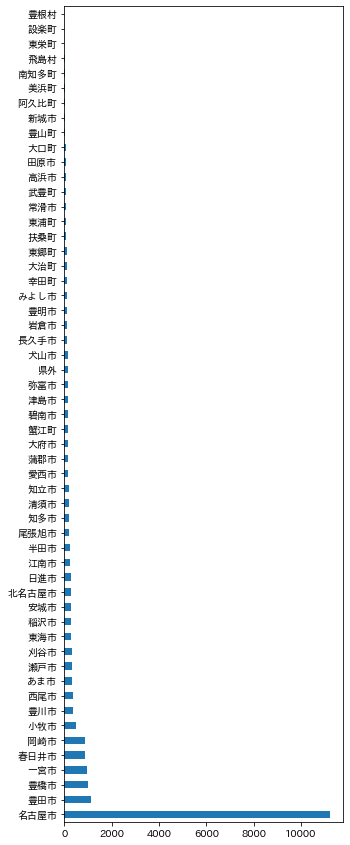

In [48]:
df["住居地"].value_counts().plot.barh(figsize=(5, 15))

In [49]:
df["住居地"].value_counts().reindex(aichi_cities, fill_value=0)

名古屋市     11218
一宮市        962
瀬戸市        328
春日井市       887
犬山市        140
江南市        261
小牧市        489
稲沢市        292
尾張旭市       218
岩倉市        134
豊明市        129
日進市        268
清須市        207
北名古屋市      269
長久手市       139
東郷町         98
豊山町         51
大口町         67
扶桑町         95
津島市        161
愛西市        180
弥富市        157
あま市        341
大治町        110
蟹江町        166
飛島村         17
半田市        254
常滑市         86
東海市        305
大府市        174
知多市        213
阿久比町        33
東浦町         86
南知多町        24
美浜町         26
武豊町         86
岡崎市        866
碧南市        165
刈谷市        325
豊田市       1113
安城市        281
西尾市        363
知立市        190
高浜市         77
みよし市       123
幸田町        114
豊橋市        997
豊川市        367
蒲郡市        178
新城市         49
田原市         67
設楽町          2
東栄町          3
豊根村          1
Name: 住居地, dtype: int64

# 性別

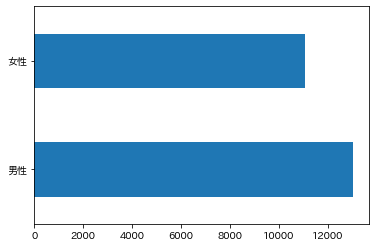

In [50]:
df["性別"].value_counts().plot.barh()

In [51]:
# 性別 欠損数
df["性別"].isna().sum()

0

In [52]:
# 性別
df["性別"].value_counts()

男性    13039
女性    11062
Name: 性別, dtype: int64

# 年代確認

## 置換前

In [53]:
# ユニーク確認
df["年代"].unique()

array(['60代', '50代', '80代', '70代', '20代', '40代', '30代', '90代', '10歳未満',
       '10代', '100代', '高齢者', 'ー代'], dtype=object)

In [54]:
df["年代"].value_counts()

20代      5607
30代      3540
40代      3358
50代      3168
60代      2061
70代      2040
10代      1679
80代      1437
10歳未満     789
90代       407
100代       13
ー代          1
高齢者         1
Name: 年代, dtype: int64

## 確認

In [55]:
# リスト外
df[~df["年代"].isin(ages_list)]

,発表日,年代・性別,国籍,住居地,接触状況,備考,年代,性別
No,,,,,,,,
5543,2020-10-11,高齢者女性,NaN,名古屋市,NaN,名古屋市発表2999,高齢者,女性
13890,2020-12-19,ー代女性,NaN,豊橋市,NaN,豊橋市発表347,ー代,女性


## 置換後 

In [56]:
# 10歳未満代を10歳未満に置換
df["年代"] = df["年代"].replace("10歳未満代", "10歳未満")

In [57]:
# リスト外をその他に置換
df["年代"] = df["年代"].where(df["年代"].isin(ages_list), "その他")

In [58]:
df["年代"].unique()

array(['60代', '50代', '80代', '70代', '20代', '40代', '30代', '90代', '10歳未満',
       '10代', '100代', 'その他'], dtype=object)

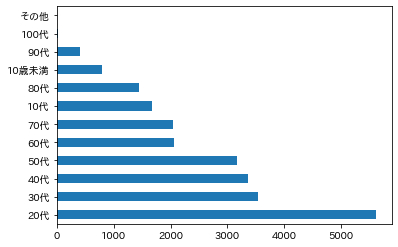

In [59]:
df["年代"].value_counts().plot.barh()

In [60]:
df["年代"].value_counts()

20代      5607
30代      3540
40代      3358
50代      3168
60代      2061
70代      2040
10代      1679
80代      1437
10歳未満     789
90代       407
100代       13
その他         2
Name: 年代, dtype: int64

# 市町村別年代

In [61]:
df_area_ages = pd.crosstab(df["住居地"], df["年代"]).reindex(index=aichi_cities + ["県外"], columns=ages_list + ["その他"], fill_value=0)
df_area_ages

年代,10歳未満,10代,20代,30代,40代,50代,60代,70代,80代,90代,100代,その他
住居地,,,,,,,,,,,,
名古屋市,331,532,2909,1810,1505,1335,971,860,708,247,9,1
一宮市,27,80,189,115,111,151,85,110,84,10,0,0
瀬戸市,9,21,74,53,51,47,24,29,17,3,0,0
春日井市,22,93,180,99,134,133,68,93,57,8,0,0
犬山市,4,26,21,19,22,16,19,9,2,2,0,0
江南市,8,28,45,22,29,46,29,31,20,3,0,0
小牧市,29,55,90,69,81,80,30,30,17,8,0,0
稲沢市,7,22,64,34,39,46,16,41,21,2,0,0
尾張旭市,8,27,53,27,26,26,23,16,11,1,0,0


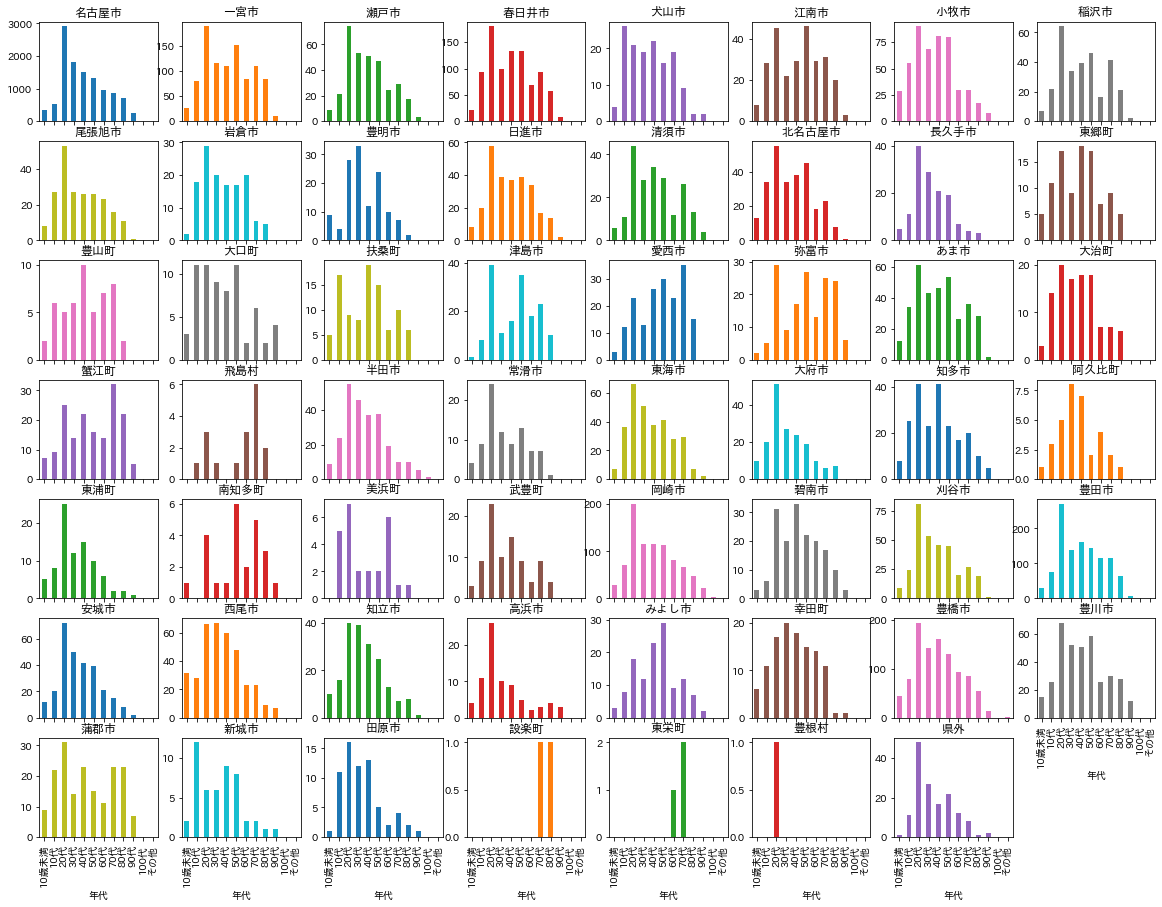

In [62]:
df_area_ages.T.plot.bar(subplots=True, layout=(7, 8), figsize=(20, 15), legend=False);

In [63]:
df_area_sex = pd.crosstab(df["住居地"], df["性別"]).reindex(index=aichi_cities + ["県外"], columns=["男性", "女性", "その他"], fill_value=0)
df_area_sex

性別,男性,女性,その他
住居地,,,
名古屋市,6005,5213,0
一宮市,497,465,0
瀬戸市,184,144,0
春日井市,519,368,0
犬山市,72,68,0
江南市,148,113,0
小牧市,249,240,0
稲沢市,164,128,0
尾張旭市,112,106,0


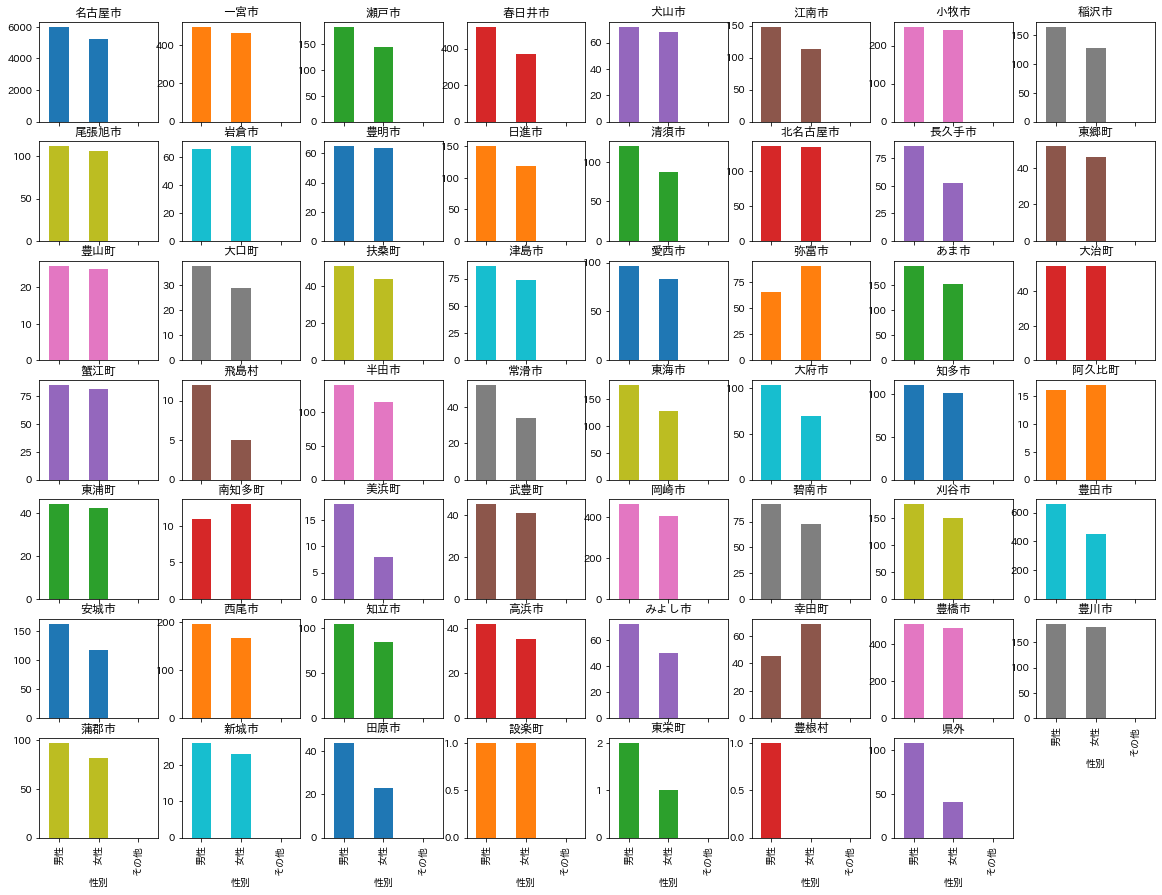

In [64]:
df_area_sex.T.plot.bar(subplots=True, layout=(7, 8), figsize=(20, 15), legend=False);

# 年代別性別

In [65]:
df_ages_sex = pd.crosstab(df["年代"], df["性別"]).reindex(index=ages_list + ["その他"], columns=["男性", "女性", "その他"], fill_value=0)
df_ages_sex

性別,男性,女性,その他
年代,,,
10歳未満,398,391,0
10代,920,759,0
20代,2969,2638,0
30代,2001,1539,0
40代,1995,1363,0
50代,1775,1393,0
60代,1205,856,0
70代,1034,1006,0
80代,621,816,0


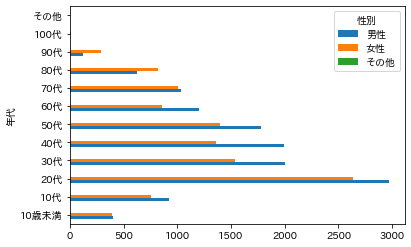

In [66]:
df_ages_sex.plot.barh()